SENTIMENT ANALYSIS

https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset/data

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_data = pd.read_csv('/content/drive/MyDrive/dataset/train.csv',encoding='unicode_escape');
test_data = pd.read_csv('/content/drive/MyDrive/dataset/test.csv',encoding='latin1');

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
train_data.head()


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [8]:
test_data.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [9]:
train_data.describe()

,Population -2020,Land Area (Km²),Density (P/Km²)
count,2.748100e+04,2.748100e+04,27481.000000
mean,4.018497e+07,6.621730e+05,357.686583
std,1.504946e+08,1.807425e+06,2013.750702
min,8.010000e+02,0.000000e+00,2.000000
25%,1.968001e+06,2.281000e+04,35.000000
50%,8.655535e+06,1.118900e+05,89.000000
75%,2.843594e+07,5.279700e+05,214.000000
max,1.439324e+09,1.637687e+07,26337.000000


In [10]:
train_data.isna().any()

textID              False
text                 True
selected_text        True
sentiment           False
Time of Tweet       False
Age of User         False
Country             False
Population -2020    False
Land Area (Km²)     False
Density (P/Km²)     False
dtype: bool

In [11]:
test_data.isna().any()

textID              True
text                True
sentiment           True
Time of Tweet       True
Age of User         True
Country             True
Population -2020    True
Land Area (Km²)     True
Density (P/Km²)     True
dtype: bool

In [12]:
train_data = train_data.dropna()

Data Exploration :

In [13]:
# Display the structure of the dataset
print("Dataset Structure:")
print(train_data.info())

# Display the first few rows of the dataset
print("\nSample Data:")
print(train_data.head())

# Check the size of the dataset
print("\nDataset Size:")
print("Number of rows:", len(train_data))
print("Number of columns:", len(train_data.columns))

# Identify key variables
print("\nKey Variables:")
print("Text Content Variable:", train_data.columns[3])  # Assuming text content is in the 4th column
print("Sentiment Labels Variable:", train_data.columns[1])  # Assuming sentiment labels are in the 2nd column


Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27480 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27480 non-null  object 
 4   Time of Tweet     27480 non-null  object 
 5   Age of User       27480 non-null  object 
 6   Country           27480 non-null  object 
 7   Population -2020  27480 non-null  int64  
 8   Land Area (Km²)   27480 non-null  float64
 9   Density (P/Km²)   27480 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.3+ MB
None

Sample Data:
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138               

In [16]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['text'])
text_sequences = tokenizer.texts_to_sequences(train_data['text'])
text_data = pad_sequences(text_sequences, maxlen=50)

# Encode categorical data
ohe = OneHotEncoder()
categorical_data = ohe.fit_transform(train_data[['Time of Tweet', 'Age of User', 'Country']]).toarray()

# Scale numerical data
scaler = StandardScaler()
numerical_data = scaler.fit_transform(train_data[['Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']])

# Prepare target
target = pd.get_dummies(train_data['sentiment']).values

In [17]:
# Split the data
X_train_text, X_dev_text, X_train_cat, X_dev_cat, X_train_num, X_dev_num, y_train, y_dev = train_test_split(
    text_data, categorical_data, numerical_data, target, test_size=0.2, random_state=42
)

# Model
text_input = Input(shape=(50,))
text_embed = Embedding(input_dim=10000, output_dim=128)(text_input)
text_out = LSTM(64)(text_embed)

cat_input = Input(shape=(categorical_data.shape[1],))
num_input = Input(shape=(numerical_data.shape[1],))

merged = concatenate([text_out, cat_input, num_input])

dense = Dense(64, activation='relu')(merged)
output = Dense(3, activation='softmax')(dense)

model = Model(inputs=[text_input, cat_input, num_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
model.fit([X_train_text, X_train_cat, X_train_num], y_train, epochs=20, batch_size=32)

Epoch 1/20
687/687 [==============================] - 36s 48ms/step - loss: 0.8064 - accuracy: 0.6279
Epoch 2/20
687/687 [==============================] - 32s 47ms/step - loss: 0.5508 - accuracy: 0.7796
Epoch 3/20
687/687 [==============================] - 31s 45ms/step - loss: 0.4319 - accuracy: 0.8323
Epoch 4/20
687/687 [==============================] - 34s 50ms/step - loss: 0.3402 - accuracy: 0.8707
Epoch 5/20
687/687 [==============================] - 33s 48ms/step - loss: 0.2591 - accuracy: 0.9019
Epoch 6/20
687/687 [==============================] - 31s 46ms/step - loss: 0.1984 - accuracy: 0.9246
Epoch 7/20
687/687 [==============================] - 31s 45ms/step - loss: 0.1549 - accuracy: 0.9420
Epoch 8/20
687/687 [==============================] - 31s 45ms/step - loss: 0.1227 - accuracy: 0.9531
Epoch 9/20
687/687 [==============================] - 31s 45ms/step - loss: 0.0926 - accuracy: 0.9661
Epoch 10/20
687/687 [==============================] - 31s 45ms/step - loss: 0.070

In [18]:
# Evaluate the model
model.evaluate([X_dev_text, X_dev_cat, X_dev_num], y_dev)

172/172 [==============================] - 2s 10ms/step - loss: 3.2939 - accuracy: 0.6719


[3.2939090728759766, 0.6719432473182678]

In [19]:
# Function to preprocess and predict sentiment
def preprocess_and_predict(df, model, tokenizer, ohe, scaler):
    predictions = []
    indices = []

    for idx, row in df.iterrows():
        # Check for nulls in the columns needed for each input type
        if pd.isnull(row['text']) or pd.isna(row['text']):
            continue  # Skip this row if text data is missing

        # Prepare text data
        seq = tokenizer.texts_to_sequences([row['text']])
        text_data = pad_sequences(seq, maxlen=50)

        # Prepare categorical data
        if pd.isnull(row[['Time of Tweet', 'Age of User', 'Country']]).any():
            continue  # Skip this row if any categorical data is missing

        cat_data = ohe.transform([row[['Time of Tweet', 'Age of User', 'Country']]]).toarray()

        # Prepare numerical data
        if pd.isnull(row[['Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']]).any():
            continue  # Skip this row if any numerical data is missing

        num_data = scaler.transform([row[['Population -2020', 'Land Area (Km²)', 'Density (P/Km²)']]])

        # Predict sentiment
        pred = model.predict([text_data, cat_data, num_data],verbose=0)
        predicted_class = np.argmax(pred, axis=1)
        predictions.append(predicted_class)
        indices.append(idx)

    return predictions, indices

# Clean and preprocess test data
df_test = test_data

# Handle missing values and predict
predicted_labels, valid_indices = preprocess_and_predict(df_test, model, tokenizer, ohe, scaler)

# Extract actual labels for valid indices
actual_labels = df_test.loc[valid_indices, 'sentiment']
actual_labels_encoded = pd.get_dummies(actual_labels).values

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWa

In [20]:
# Convert one-hot encoded actual labels to class labels
actual_labels_encoded = pd.get_dummies(actual_labels).values
actual_labels_class = np.argmax(actual_labels_encoded, axis=1)

# Generate classification report
report = classification_report(actual_labels_class, np.array(predicted_labels).flatten(), target_names=['negative', 'neutral', 'positive'])
print(report)

              precision    recall  f1-score   support

    negative       0.67      0.66      0.66      1001
     neutral       0.65      0.64      0.65      1430
    positive       0.73      0.75      0.74      1103

    accuracy                           0.68      3534
   macro avg       0.68      0.68      0.68      3534
weighted avg       0.68      0.68      0.68      3534



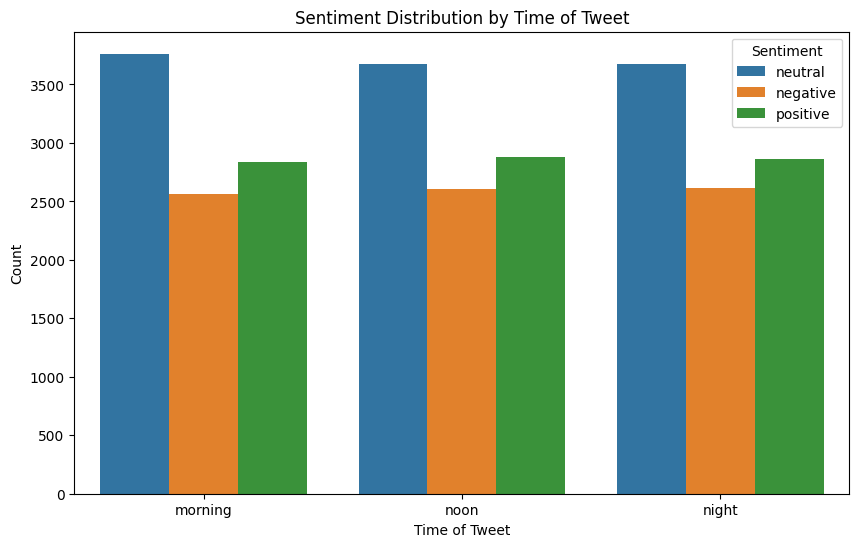

In [21]:
# Plotting figure of Time of Tweet vs Sentiment
df = train_data[['Time of Tweet','sentiment']]
plt.figure(figsize=(10, 6))
sns.countplot(x='Time of Tweet', hue='sentiment', data=df)
plt.title('Sentiment Distribution by Time of Tweet')
plt.xlabel('Time of Tweet')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

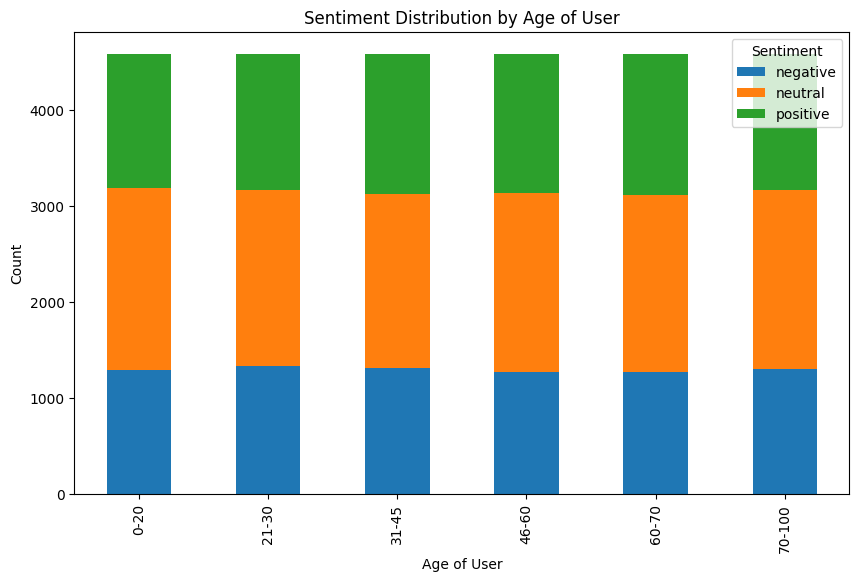

In [22]:
df = train_data[['Age of User','sentiment']]

# Create a cross-tabulation
age_sentiment = pd.crosstab(df['Age of User'], df['sentiment'])

# Plotting Age vs Sentiment
age_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution by Age of User')
plt.xlabel('Age of User')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

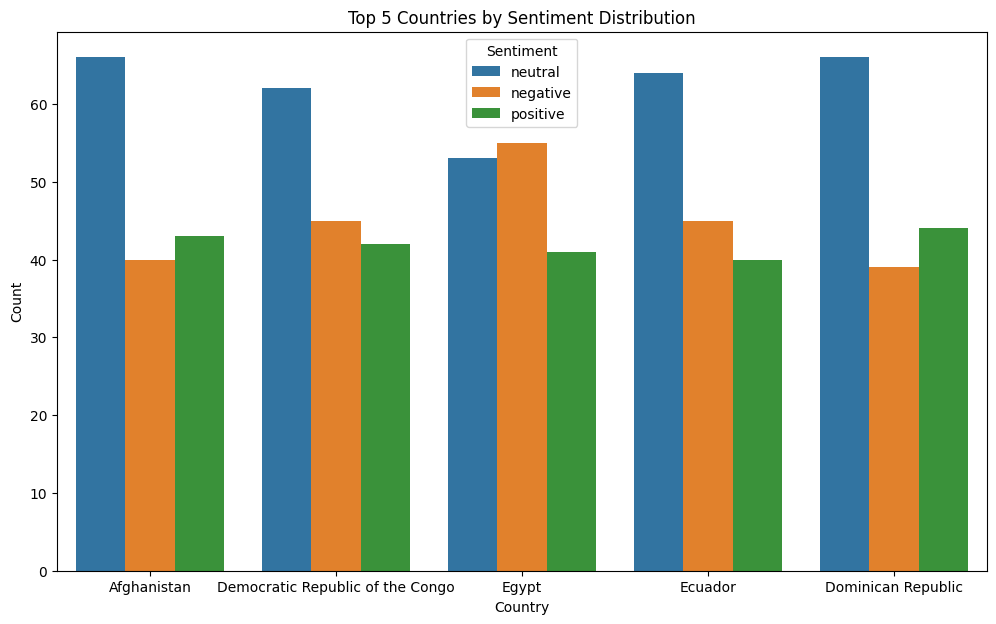

In [23]:
df = train_data[['Country','sentiment']]

# Plotting
plt.figure(figsize=(12, 7))
sns.countplot(x='Country', hue='sentiment', data=df, order=df['Country'].value_counts().iloc[:5].index)
plt.title('Top 5 Countries by Sentiment Distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

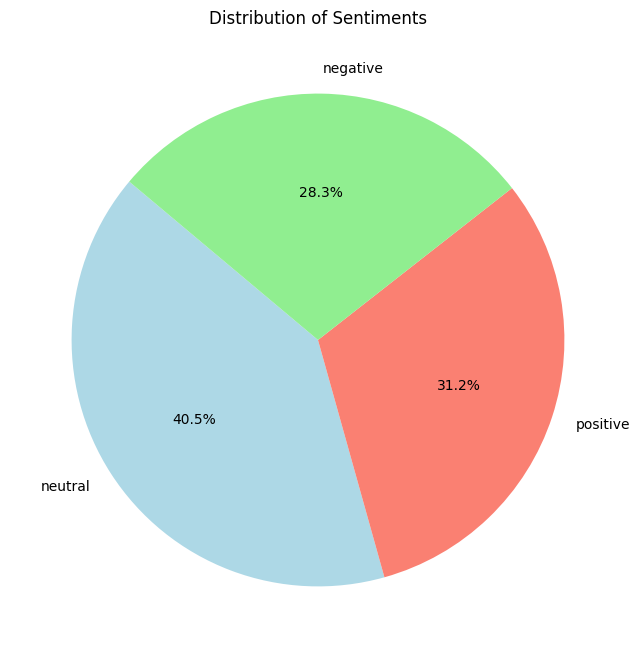

In [24]:
sentiment_counts = train_data['sentiment'].value_counts()
# Plotting of Distribution of Sentiments
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Sentiments')
plt.show()
